# Create Contours and Translations for DAVIS 2016 Dataset

## Imports

In [1]:
import os
import re

import cv2
import matplotlib.pyplot as plt
import numpy as np

from scipy.spatial.distance import cdist
from sklearn.preprocessing import normalize

import src.config as cfg

%matplotlib inline

## Paths & Constants

In [2]:
! rm -rf DAVIS_2016/DAVIS/Contours
! rm -rf DAVIS_2016/DAVIS/Translations

In [3]:
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

## Functions

In [4]:
def load_gray_img(img_path):
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img_gray

In [5]:
def close_image(image, closing_kernel_size):
    '''Returns the image that is closed with a elliptical kernel.'''
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(closing_kernel_size, closing_kernel_size))
    closing = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    
    return closing

In [6]:
def extract_longest_contour(image, closing_kernel_size, method):
    '''Returns the contour with the most points from a given image.'''
    
    # Close image
    image_closed = close_image(image, closing_kernel_size)
    
    # Apply threshold to turn it into binary image
    ret, thresh = cv2.threshold(image_closed, 127, 255, 0)

    # Find contour
    # Change method for different number of points:
    # CHAIN_APPROX_NONE, CHAIN_APPROX_SIMPLE, CHAIN_APPROX_TC89_L1, CHAIN_APPROX_TC89_KCOS
    contours, _ = cv2.findContours(image=thresh,
                                   mode=cv2.RETR_TREE,
                                   method=method)
    
    # Get longest contour from contours
    longest_contour = max(contours, key=len).astype(np.float32)
    
    return longest_contour

In [7]:
def get_normalized_translations(contour_0, contour_1):
    '''Returns the translations for each point in contour_0 to contour_1.'''
    
    contour_0 = np.squeeze(contour_0)
    contour_1 = np.squeeze(contour_1)
    
    translations = contour_1 - contour_0
    
    translations_normalized = normalize(translations)

    return translations_normalized

In [8]:
def save_annotation_with_contour_and_translation(annotation, contour, translation, path):
    '''Saves annotation plotted with contour and translation to a given path.'''
    
    plt.figure(figsize=(15,10))
    
    # Plot contour
    contour = np.squeeze(contour)
    plt.scatter(contour[:, 0], contour[:, 1])
    
    # Plot annotation
    plt.imshow(annotation)
    
    # Plot translation
    for c, t in zip(contour, translation):
        plt.arrow(c[0], c[1],
                  t[0], t[1],
                  width=1, color='r')  
    
    # Save image
    plt.savefig(path, bbox_inches=0)    
    plt.close()

In [9]:
def find_closest(contour_point_1, contour_1_real):
    contour_1_real = np.squeeze(contour_1_real, axis=1)
    dist = cdist(contour_point_1, contour_1_real, metric='euclidean')
    arg_contour_point_1_final = np.argmin(dist)
    contour_point_1_final = contour_1_real[arg_contour_point_1_final]
    #print('contour_point_1:', contour_point_1, '--> contour_point_1_final:', contour_point_1_final)
    return contour_point_1_final
    
def match_points(contour_1, contour_1_real):
    '''Match points based on minimal distance. 2 points can be matched to the same point if it is the closest'''
    rows_1, _, _ = contour_1.shape
    contour_1_final = np.zeros((rows_1, 2))
    for x in range(rows_1):
        contour_1_final[x] = find_closest(contour_1[x], contour_1_real)
    return contour_1_final

In [10]:
def create_contours_and_translations(annotations_folders_path,
                                     contours_folders_path,
                                     translations_folders_path,
                                     closing_kernel_size):

    # Get list of sequences
    sequences = os.listdir(annotations_folders_path)
    sequences.sort()
    
    # Iterate through sequences
    for i, sequence in enumerate(sequences):

        # Debug
        #if (i > 6): break
        print('#{}: {}'.format(i, sequence))
        
        if sequence not in cfg.TRAIN_SEQUENCES:
            augmentation_count = 1
        else:
            augmentation_count = cfg.AUGMENTATION_COUNT
                                             
        # Iterate through augmentations:
        for j in range(augmentation_count):
            
            j = str(j)
            
            print('\t{} #{}'.format('Augmentation', j))
        
            # Create folder to save Contours
            contours_folder_path = os.path.join(contours_folders_path, sequence, j)
            if not os.path.exists(contours_folder_path):
                os.makedirs(contours_folder_path)

            # Create folder to save Translations
            translations_folder_path = os.path.join(translations_folders_path, sequence, j)
            if not os.path.exists(translations_folder_path):
                os.makedirs(translations_folder_path)

            # Get list of frames
            frames = os.listdir(os.path.join(annotations_folders_path, sequence, j))
            if '.ipynb_checkpoints' in frames:
                frames.remove('.ipynb_checkpoints')
            frames.sort()
        
            # Iterate through frames
            for k, frame in enumerate(frames):

                # Debug
                #if (k > 2): break
                print('\t\t#{}: {}'.format(k, frame))

                if (sequence == 'bmx-bumps' and frame == '00059.png'): break
                if (sequence == 'surf' and frame == '00053.png'): break

                # Get path to frames
                frame_0_path = os.path.join(annotations_folders_path, sequence, j, frame)
                try:
                    frame_1_path = os.path.join(annotations_folders_path, sequence, j, frames[k+1])
                # Break if frame_0 is last frame
                except IndexError as e:
                    break

                # Load frames as gray img
                frame_0_gray = load_gray_img(frame_0_path)
                frame_1_gray = load_gray_img(frame_1_path)

                # Extract longest contour and save it
                contour_0 = extract_longest_contour(frame_0_gray, closing_kernel_size, cv2.CHAIN_APPROX_TC89_KCOS)
                np.save(os.path.join(contours_folder_path, frame[:5]), contour_0)

                # Calculate optical flow to get contour_1
                contour_1, st, err = cv2.calcOpticalFlowPyrLK(frame_0_gray, frame_1_gray, 
                                                              contour_0, None, **lk_params)

                translation_0_1_normalized = get_normalized_translations(contour_0, contour_1)

                # Update contour_1 with normalized translations
                contour_1 = np.add(np.squeeze(contour_0), translation_0_1_normalized)
                contour_1 = np.expand_dims(contour_1, axis=1)

                contour_1_real = extract_longest_contour(frame_1_gray, closing_kernel_size, cv2.CHAIN_APPROX_NONE)

                # Match contour 1 on contour 1 real
                contour_1_final = match_points(contour_1, contour_1_real)

                # Get translation and save it
                translation_0_1_final = contour_1_final - np.squeeze(contour_0)

                correction = np.mean(np.linalg.norm(translation_0_1_normalized-translation_0_1_final, axis=1))
                #print('\t-> Mean correction after projecting on real contour:', np.mean(translation_0_1-translation_0_1_final))

                np.save(os.path.join(translations_folder_path, frame[:5]), translation_0_1_final)

                # Save annotation with contour and translation
                #annotation = cv2.imread(os.path.join(annotations_folders_path, sequence, j, frame))
                #save_annotation_with_contour_and_translation(annotation, contour_0, translation_0_1_final, 
                #    os.path.join(translations_folder_path, frame[:5] + '.png'))         

## Create Contours and Translations

#0: bear
	Augmentation #0
	Augmentation #1


KeyboardInterrupt: 

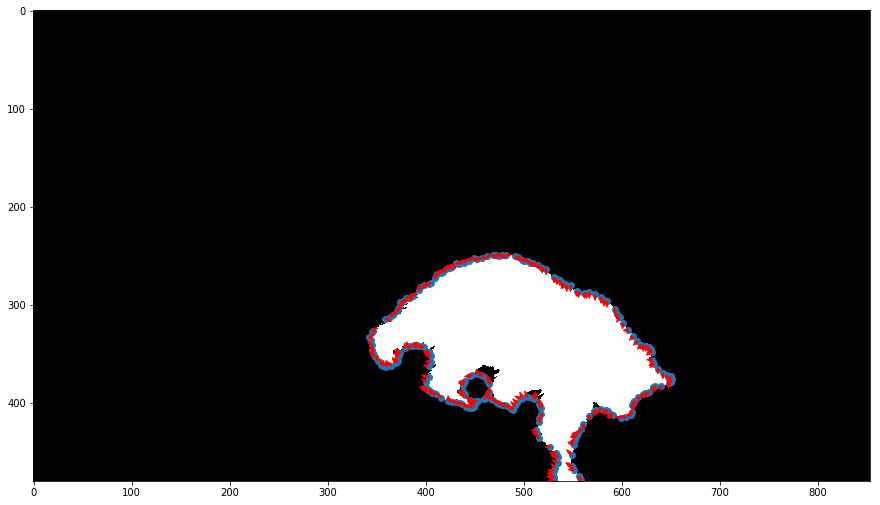

In [11]:
create_contours_and_translations(cfg.ANNOTATIONS_AUGMENTED_FOLDERS_PATH,
                                 cfg.CONTOURS_FOLDERS_PATH,
                                 cfg.TRANSLATIONS_FOLDERS_PATH,
                                 cfg.CLOSING_KERNEL_SIZE)